In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
from scipy.spatial import cKDTree
from scipy.optimize import minimize
import PredictImage as prim
import os

In [2]:
cur_cam_index = 7
K = np.array([
    [3253.45225, -3.08866451, 4745.21992],
    [0.0, 3252.26117, 3142.22723],
    [0.0, 0.0, 1.0]
], dtype=np.float64)

#D = np.array([0.05003216, -0.04567757, 0.06960187, -0.03096402], dtype=np.float64)
D =np.array([  0.08330459003495257, 0.008459725805467274,  0.000681253494528032, 0.0001603712146519313])

image_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c8_img20250512-12_06_55CEST.jpg"
overlay_filename_current = "C:\\Users\\ablai\\Documents\\photogrammetry\\led-runs-12may2025\\led-runs-12may2025\\c8_img20250512-11_57_42CEST.jpg"


delta_pitch_deg=3.0
delta_yaw_deg=5.0 
delta_roll_deg=2.0 
delta_r=0.000

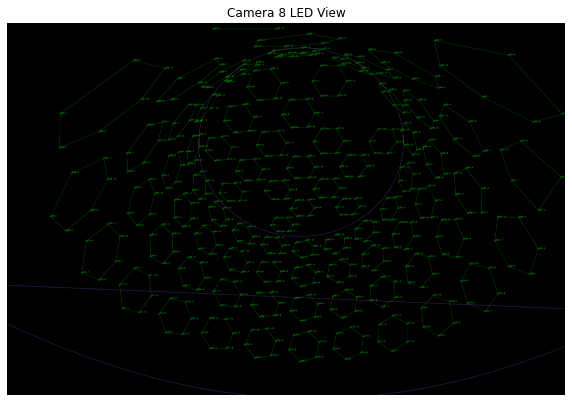

Saved image to camera8_f3253_p3_y5_r2_dr0.png


In [3]:
excluded_pmts = { 5, 9, 15, 19, 21, 26, 27, 30, 33, 34, 35, 36, 37, 
                 45, 49, 50, 51, 52, 57,
                 63,  67, 74,  77, 79, 83 }

prim.simulate_fisheye_view("wcte_geometry_file.json", camera_index=cur_cam_index, K=K, D=D, delta_pitch_deg=delta_pitch_deg, delta_yaw_deg=delta_yaw_deg, delta_roll_deg=delta_roll_deg, delta_r=delta_r, excluded_pmts={})

In [4]:

blobs = prim.run_blob_detector( cur_cam_index, image_filename_current, minarea=10, maxarea=5000, minthres=1, maxthres=255 )
print('number of blobs before filter:',len(blobs))
blobs_filtered = prim.filter_blobs_by_distance(blobs, 25)
print('number of blobs:',len(blobs_filtered))

number of blobs before filter: 495
number of blobs: 488


In [5]:
prim.draw_image_with_blobs_save( cur_cam_index, image_filename_current, blobs_filtered, 'c'+str(cur_cam_index+1)+'_with_blob_annotation.jpg' )

Annotated image saved to: c8_with_blob_annotation.jpg


In [6]:

# Initial guess: [pitch, yaw, roll, r, k1, k2, k3, k4]
initial_guess = [delta_pitch_deg, delta_yaw_deg, delta_roll_deg, delta_r, 
                 D[0], D[1], D[2], D[3] ]

control_points = { 
    '071-6': (1961, 4379),
    '062-6': (6725, 4391),
    '062-7': (6936, 4460),
    '062-8': (7111, 4253),
    '064-8': (7875, 2875),
    '006-8': (4690, 1072)
}

# non-fit bounts
dev_allowed = 15.0
bounds = [ (delta_pitch_deg-dev_allowed, delta_pitch_deg+dev_allowed),   # delta_pitch_deg
           (delta_yaw_deg-dev_allowed, delta_yaw_deg+dev_allowed),   # delta_yaw_deg
           (delta_roll_deg-dev_allowed, delta_roll_deg+dev_allowed),   # delta_roll_deg
           (-0.02, 0.02), # delta_r in meters
           (-0.1, 0.1), # k1 [ 0.05003216 -0.04567757  0.06960187 -0.03096402]
           (-0.009, 0.009), # k2
           (-0.0008, 0.0008), # k3
           (-0.0002, 0.0002)   ]

matches, fitpars = prim.match_blobs( blobs_filtered, "wcte_geometry_file.json", 
                            cur_cam_index, K, D, initial_guess=initial_guess, excluded_pmts=excluded_pmts,
                            bounds = bounds, control_points=control_points,  use_lm=True)

In [7]:
fitpars

{'delta_pitch_deg': 3.5655387002873487,
 'delta_yaw_deg': 4.435388577074878,
 'delta_roll_deg': 1.6054086331702098,
 'delta_r': -0.10680293602368837,
 'D_fit': array([ 0.01249645,  0.70500331, -1.15075645,  0.5747541 ]),
 'chi2': 7461209.22756972,
 'success': True}

In [8]:
len(matches)

241

In [9]:
matches

[('000-6', 5105.848, 2271.6167),
 ('000-7', 4867.193, 2276.9307),
 ('001-6', 4610.289, 1840.5702),
 ('001-7', 4354.8516, 1855.9292),
 ('001-11', 4755.596, 2041.679),
 ('002-6', 4196.5205, 2305.0923),
 ('002-7', 3979.1367, 2319.39),
 ('002-8', 3906.7341, 2503.1),
 ('002-11', 4333.244, 2473.1697),
 ('003-7', 4709.7285, 2986.1362),
 ('003-9', 4682.299, 2669.5632),
 ('003-10', 4459.6206, 2676.6348),
 ('004-9', 5108.922, 3000.1475),
 ('004-10', 4897.8228, 3004.302),
 ('006-6', 5736.4287, 2628.5525),
 ('006-7', 5954.988, 2631.1443),
 ('006-8', 6090.4595, 2457.253),
 ('006-9', 6005.1675, 2276.016),
 ('006-10', 5775.722, 2272.201),
 ('006-11', 5641.6, 2454.827),
 ('007-7', 5573.0435, 2234.0303),
 ('007-9', 5595.3403, 1828.5181),
 ('007-10', 5337.7676, 1827.5638),
 ('007-11', 5208.551, 2035.864),
 ('008-6', 5097.131, 1340.2317),
 ('008-7', 4819.021, 1346.8639),
 ('008-8', 4696.024, 1579.8875),
 ('008-9', 4840.6772, 1795.313),
 ('008-10', 5103.969, 1789.5061),
 ('008-11', 5236.027, 1568.8182),
 

In [10]:
img = prim.visualize_all_leds_and_matches( 
    image_filename_current,
    blobs,
    matches,
    fitpars,
    "wcte_geometry_file.json",
    cur_cam_index,
    K,
    fitpars['D_fit'],
    output_filename='c'+str(cur_cam_index+1)+"_blob_match_overlay.png",
    excluded_pmts=excluded_pmts,
    control_points=control_points,
    overlay_image_name=overlay_filename_current,
    alpha=0.2
)


{'delta_pitch_deg': 3.5655387002873487, 'delta_yaw_deg': 4.435388577074878, 'delta_roll_deg': 1.6054086331702098, 'delta_r': -0.10680293602368837, 'D_fit': array([ 0.01249645,  0.70500331, -1.15075645,  0.5747541 ]), 'chi2': 7461209.22756972, 'success': True}
Overlay image saved to: c8_blob_match_overlay.png


In [11]:
output_filename = os.path.splitext( os.path.basename(image_filename_current) )[0] + ".json"

prim.save_matching_results_to_json(
    output_filename=output_filename,
    image_filename=image_filename_current,
    fitpars=fitpars, 
    matches=matches, 
    blobs=blobs, 
    geo_file="wcte_geometry_file.json", 
    camera_index=cur_cam_index, 
    K=K, 
    D=fitpars['D_fit'], 
    excluded_pmts=excluded_pmts)

excluded_pmts= {67, 5, 9, 74, 77, 15, 79, 19, 83, 21, 26, 27, 30, 33, 34, 35, 36, 37, 45, 49, 50, 51, 52, 57, 63}
geo_file= wcte_geometry_file.json
Sample matches labels: [('000-6', 5105.848, 2271.6167), ('000-7', 4867.193, 2276.9307), ('001-6', 4610.289, 1840.5702), ('001-7', 4354.8516, 1855.9292), ('001-11', 4755.596, 2041.679), ('002-6', 4196.5205, 2305.0923), ('002-7', 3979.1367, 2319.39), ('002-8', 3906.7341, 2503.1), ('002-11', 4333.244, 2473.1697), ('003-7', 4709.7285, 2986.1362)]
Sample label_to_sim keys: ['000-6', '000-7', '000-8', '000-9', '000-10', '000-11', '001-6', '001-7', '001-8', '001-9']
Saved results to c8_img20250512-12_06_55CEST.json
